In [ ]:
# Start measuring time

import tpqoa
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import pytz

start_script_time = time.time()

# Initialize tpqoa instance with your config file
api = tpqoa.tpqoa("oanda.cfg") 

# List of instruments to download
instruments = ["DE30_EUR", "EUR_CHF", "XAU_USD"]

# Calculate the date range
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=2*365)

# Convert dates to the format required by tpqoa
start_time_str = start_time.strftime("%Y-%m-%d")
end_time_str = end_time.strftime("%Y-%m-%d")


# Convert to North America Eastern Time (ET)
eastern = pytz.timezone('US/Eastern')

# Convert UTC time to Eastern Time
end_time = pytz.utc.localize(end_time).astimezone(eastern)

# Subtract 2 years (365 days * 2) from the end time to get the start time
start_time = end_time - timedelta(days=2*365)

# Convert times to the format required by tpqoa (as strings)
start_time_str = start_time.strftime("%Y-%m-%d")
end_time_str = end_time.strftime("%Y-%m-%d")

print("Start time (ET):", start_time_str)
print("End time (ET):", end_time_str)


DE30_EUR_15min = api.get_history(instrument='DE30_EUR',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='M15',
                  price='M')

DE30_EUR_1H = api.get_history(instrument='DE30_EUR',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='H1',
                  price='M')

EUR_CHF_15min = api.get_history(instrument='EUR_CHF',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='M15',
                  price='M')

EUR_CHF_1H = api.get_history(instrument='EUR_CHF',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='H1',
                  price='M')


XAU_USD_1H = api.get_history(instrument='XAU_USD',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='H1',
                  price='M')

XAU_USD_15min = api.get_history(instrument='XAU_USD',
                  start=start_time_str,
                  end=end_time_str,
                  granularity='M15',
                  price='M')


end_script_time = time.time()
print(f"Total time taken: {end_script_time - start_script_time:.2f} seconds")

Start time (ET): 2022-11-28
End time (ET): 2024-11-27


In [ ]:
#XAU_USD_15min2 = XAU_USD_15min.copy()

In [ ]:
# # Group by the date part of the index and calculate the range of hours
# df_copy = XAU_USD_15min.copy()
# df_copy['hour'] = df_copy.index.hour
# df_copy['date'] = df_copy.index.date

# hour_ranges = df_copy.groupby('date')['hour'].agg(['min', 'max'])

# # Rename columns for clarity
# hour_ranges.columns = ['start_hour', 'end_hour']
# hour_ranges = hour_ranges.reset_index()

In [ ]:
# data = XAU_USD_15min['o'] # 
# data = data.index.to_period('H').groupby( by = [data.index])
# data.insert('date',)['']
# data.groupby(by=XAU_USD_15min.index.date, as_index=False).last()

In [ ]:
def get_range(group, ticks='15 min'):
    #Calculate when to enter the strategy
    maxiumum_first_h = group[(group.index.hour >= 8) & (group.index.hour < 9)]['c'].copy().max() 
    minimum_first_h = group[(group.index.hour >= 8) & (group.index.hour < 9)]['c'].copy().min()

    trading_d = group[(group.index.hour >= 10) & (group.index.hour < 20)]
    group['signal'] = 0

    #If there is no data about 
    if not( np.isnan(maxiumum_first_h) or np.isnan(minimum_first_h) ) :

        #Analyze those that are up 
        up = trading_d['c'] > maxiumum_first_h
        down = trading_d['c'] < minimum_first_h
        
        #Check 3 scenrios, 
        # 1. Where candle was below minima and above maxima
        # 2. Where candle was above maxima
        # 3. Where candle was below minima 
    
        if len(trading_d[up]) > 0 and len(trading_d[down]) > 0:
            
            #Check if up signal was first or down signal was first
            if trading_d[up].index[0] > trading_d[down].index[0]:
                
                group.loc[trading_d[up].index[0] + pd.Timedelta(ticks) : trading_d.index[-1], 'signal'] = 1

            else:
                group.loc[trading_d[down].index[0] + pd.Timedelta(ticks): trading_d.index[-1], 'signal'] = -1
            
        elif len(trading_d[up]) > 0 :

            group.loc[trading_d[up].index[0] + pd.Timedelta(ticks): trading_d.index[-1], 'signal'] = 1

        elif len(trading_d[down]) > 0:

            group.loc[trading_d[down].index[0] + pd.Timedelta(ticks): trading_d.index[-1], 'signal'] = -1
          
    return group


In [ ]:
# Calculate strategy signals
signals = XAU_USD_15min.groupby(by=XAU_USD_15min.index.date, as_index=False).apply(get_range, ticks='15 min')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)

In [ ]:
commision = 1.4 / 10000

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]

,o,h,l,c,volume,complete,signal,returns,strategy_returns,adjusted_returns
time,,,,,,,,,,
2022-11-28 13:15:00,1753.055,1753.910,1750.365,1753.650,1075,True,-1,0.000308,-0.000308,-0.000448
2022-11-28 19:45:00,1740.440,1740.815,1739.675,1740.325,293,True,-1,-0.000115,0.000115,-0.000025
2022-11-29 12:45:00,1753.370,1755.285,1753.225,1755.285,374,True,-1,0.001118,-0.001118,-0.001258
2022-11-29 19:45:00,1750.425,1750.490,1749.545,1750.360,330,True,-1,-0.000049,0.000049,-0.000091
2022-11-30 14:00:00,1755.255,1757.955,1754.480,1757.895,1039,True,-1,0.001547,-0.001547,-0.001687
...,...,...,...,...,...,...,...,...,...,...
2024-11-22 19:45:00,2708.510,2708.710,2707.070,2708.230,2291,True,-1,-0.000105,0.000105,-0.000035
2024-11-25 10:45:00,2672.630,2678.195,2672.555,2677.805,4055,True,1,0.001931,0.001931,0.001791
2024-11-25 19:45:00,2625.172,2626.245,2624.155,2625.855,2331,True,1,0.000227,0.000227,0.000087


In [ ]:
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))


Compound returns Buy & Hold Strategy:  0.5022256462934691


In [ ]:
print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))

Compound returns ORB Strategy after commisions:  0.9930090886334959


In [ ]:
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))


Compound returns ORB Strategy Before commisions:  1.3028163377060484


In [ ]:
signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1

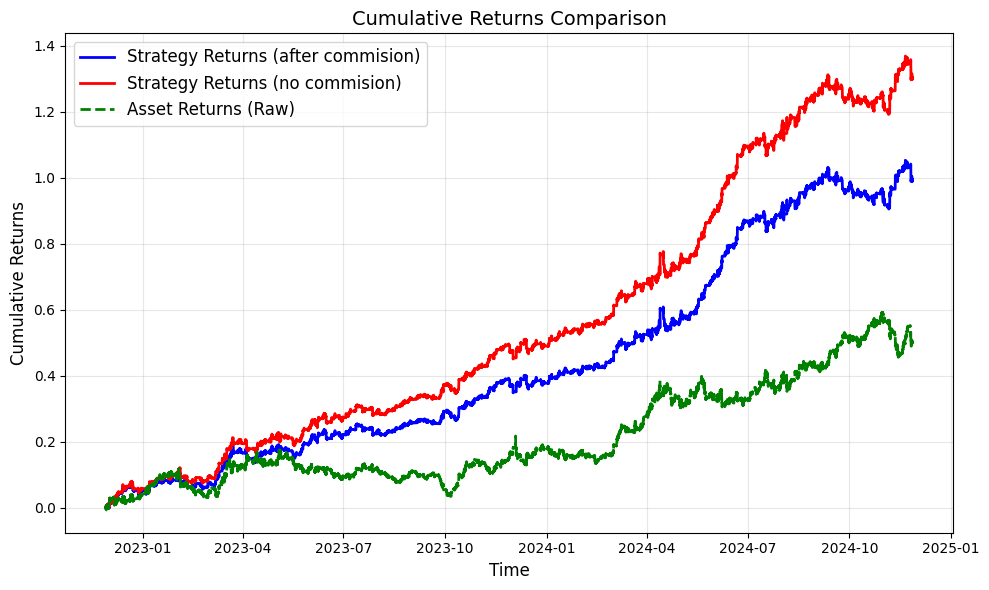

In [ ]:
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()

In [ ]:
signals[ ['adjusted_returns','returns']  ].corr()

,adjusted_returns,returns
adjusted_returns,1.00000,-0.03162
returns,-0.03162,1.00000


In [ ]:
signals[ ['strategy_returns','returns']  ].corr()

,strategy_returns,returns
strategy_returns,1.000000,-0.031681
returns,-0.031681,1.000000


In [ ]:
# Calculate win ratio for strategy
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()

0.501454898157129


,0
count,1031.000000
mean,0.000390
std,0.004754
min,-0.025907
25%,-0.001358
50%,-0.000167
75%,0.001800
max,0.022734


In [ ]:
# Calculate win ratio for Buy7 Hold
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

risk_free = 0.000171

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list )
data_str.describe()

0.5315227934044617


,0
count,1031.000000
mean,0.000238
std,0.005814
min,-0.025634
25%,-0.002841
50%,0.000137
75%,0.003276
max,0.023021


Buy & Hold Returns Metrics:
Mean: 0.000238, Std: 0.000650, Sharpe Ratio: 0.002023

Strategy Returns Metrics:
Mean: 0.000390, Std: 0.000891, Sharpe Ratio: 1.259516


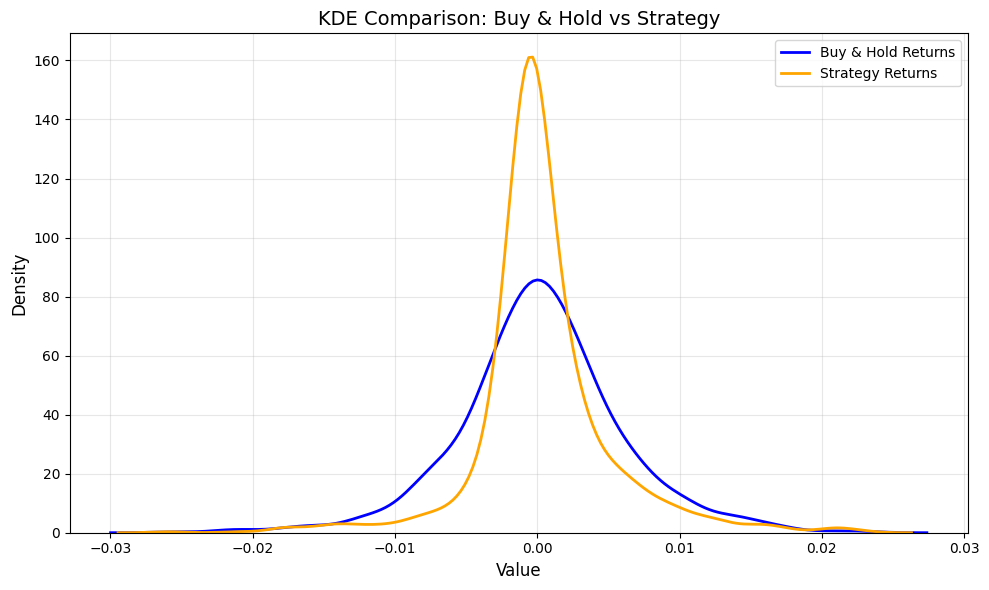

In [ ]:
# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])
risk_free = 0.00000178125 # for 15 minutes
# Calculate metrics for returns_list
mean_returns = np.mean(data_returns["Returns"] )
std_returns = signals['adjusted_returns'].std()
sharpe_returns = (signals['adjusted_returns'] - risk_free).mean() * np.sqrt(252 * 96) if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(data_strategy["Strategy Returns"])
std_strategy = signals['returns'].std()
sharpe_strategy = (signals['returns'] - risk_free).mean() * np.sqrt(252 * 96) / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<H2> Final Results</H2>

Compound returns Buy & Hold Strategy:  0.5022256462934691
Compound returns ORB Strategy after commisions:  0.9930090886334959
Compound returns ORB Strategy Before commisions:  1.3028163377060484


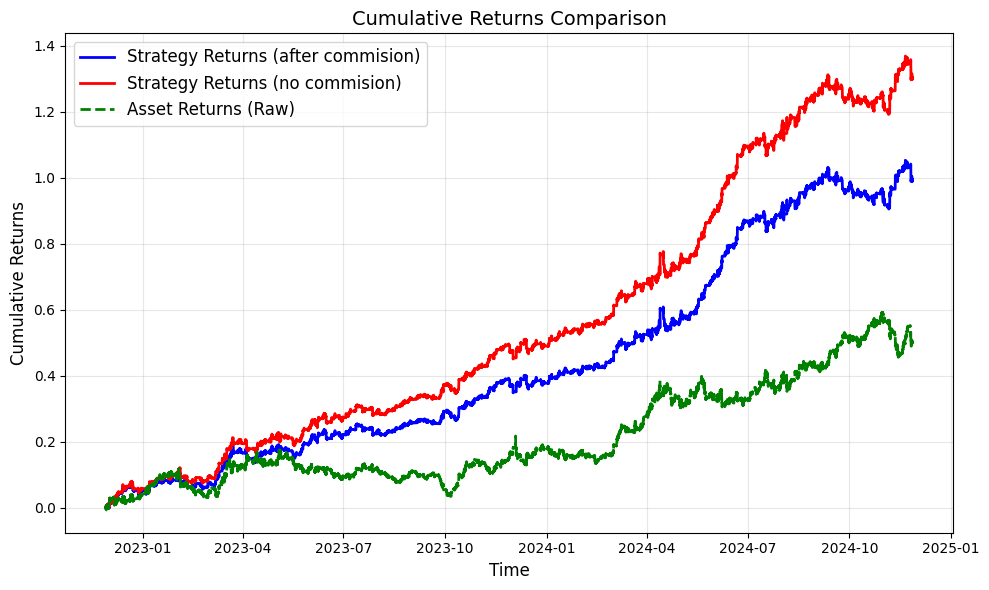

0.501454898157129
0.5315227934044617
Buy & Hold Returns Metrics:
Mean: 0.001122, Std: 0.000891, Sharpe Ratio: 1.259516

Strategy Returns Metrics:
Mean: 0.002023, Std: 0.000650, Sharpe Ratio: 3.111739


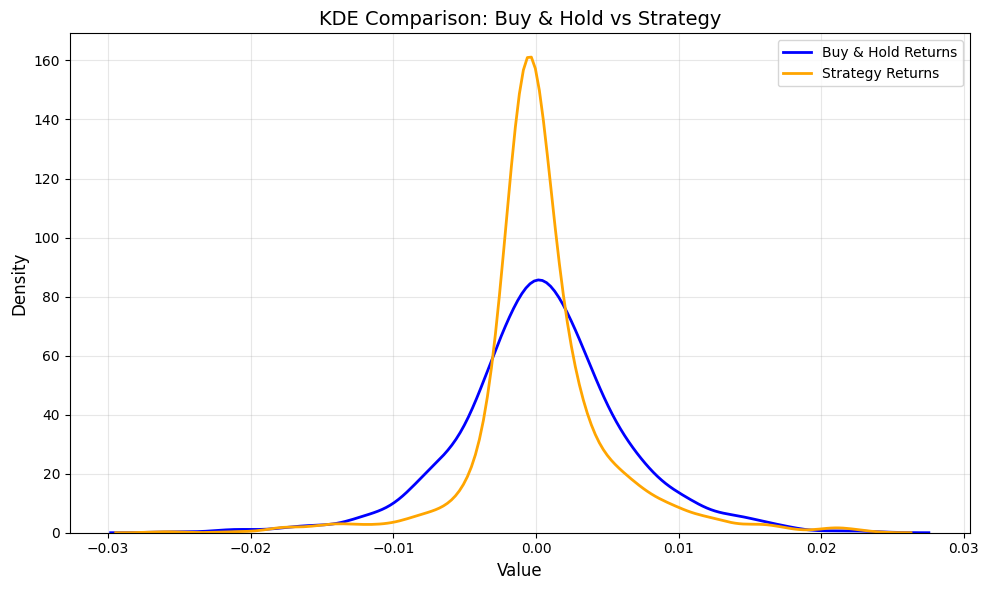

In [ ]:
# Calculate strategy signals
signals = XAU_USD_15min.groupby(by=XAU_USD_15min.index.date, as_index=False).apply(get_range, ticks='15 min')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.00000178125
annualized = np.sqrt(252 * 96)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Compound returns Buy & Hold Strategy:  0.5024914525767912
Compound returns ORB Strategy after commisions:  0.9193092614609291
Compound returns ORB Strategy Before commisions:  1.2160933958314444


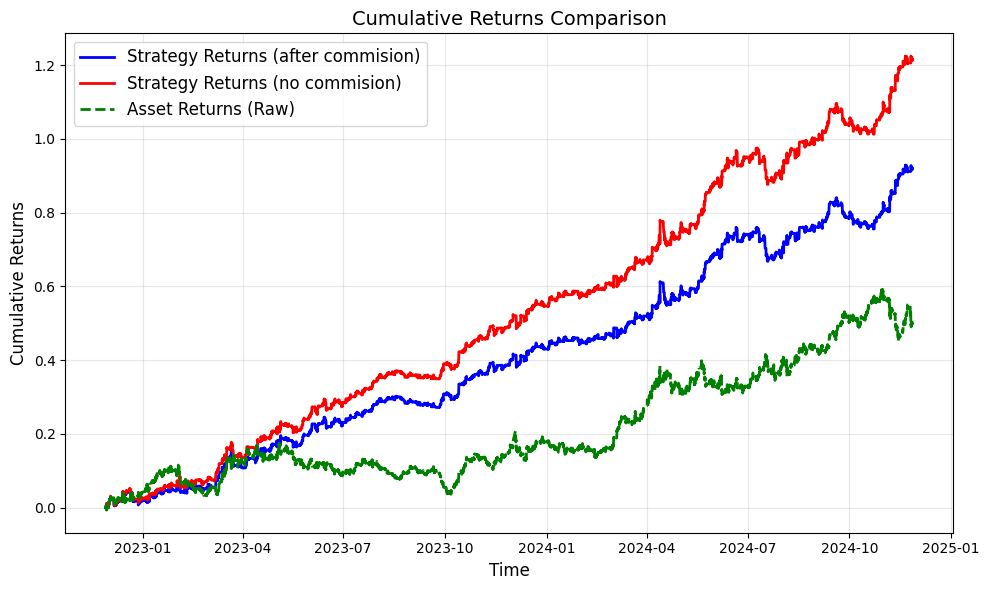

0.5272904483430799
0.5419103313840156
Buy & Hold Returns Metrics:
Mean: 0.002659, Std: 0.001775, Sharpe Ratio: 1.497903

Strategy Returns Metrics:
Mean: 0.004207, Std: 0.001258, Sharpe Ratio: 3.344663


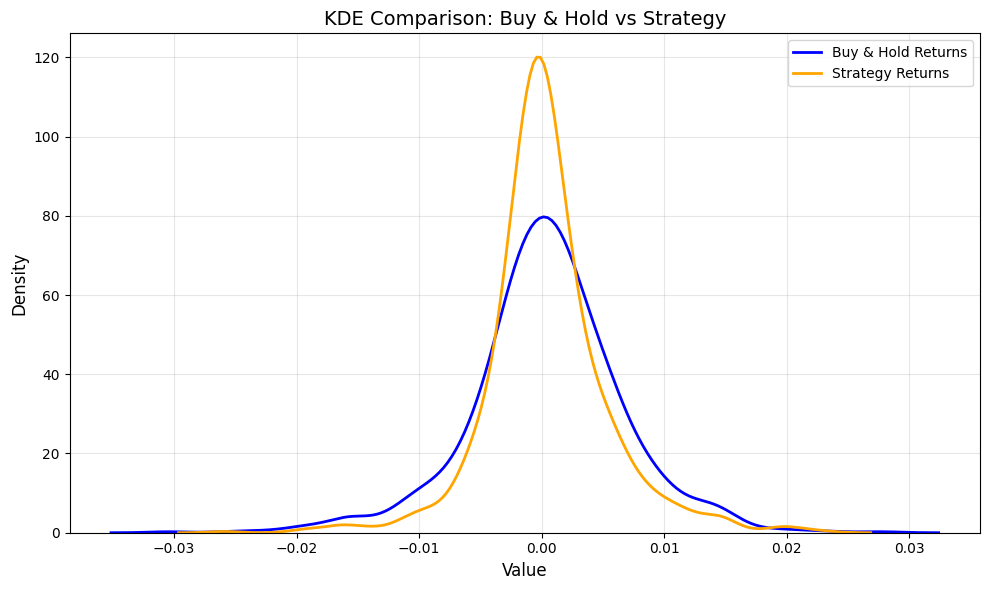

In [ ]:
# Calculate strategy signals
signals = XAU_USD_1H.groupby(by=XAU_USD_1H.index.date, as_index=False).apply(get_range, ticks='1 Hour')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.00000178125
annualized = np.sqrt(252 * 24)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Compound returns Buy & Hold Strategy:  -0.053372159322302215
Compound returns ORB Strategy after commisions:  0.15696617851177286
Compound returns ORB Strategy Before commisions:  0.3373795547686995


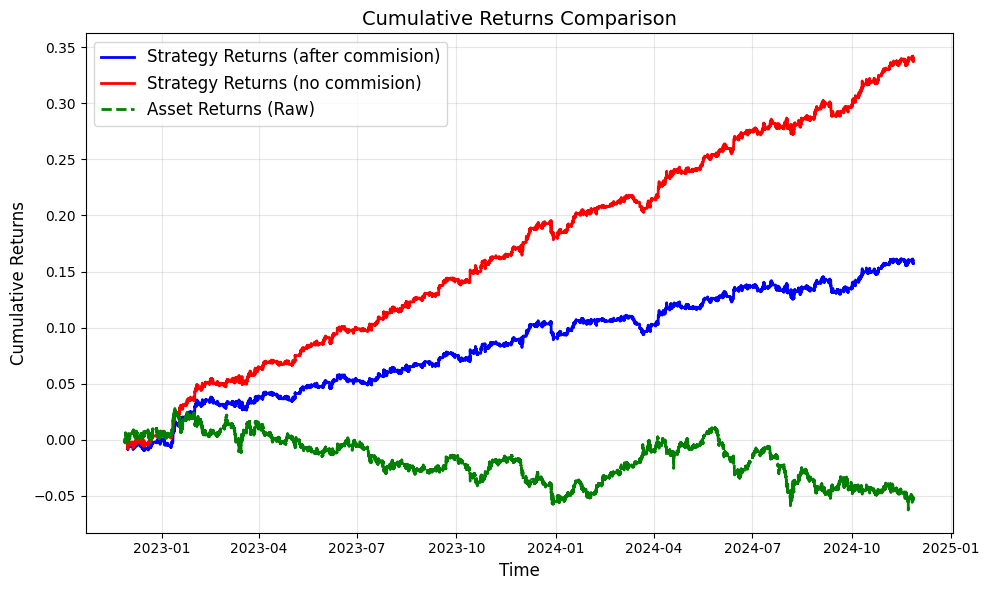

0.39748549323017407
0.5106382978723404
Buy & Hold Returns Metrics:
Mean: -0.000437, Std: 0.000376, Sharpe Ratio: -1.163532

Strategy Returns Metrics:
Mean: 0.000182, Std: 0.000230, Sharpe Ratio: 0.794109


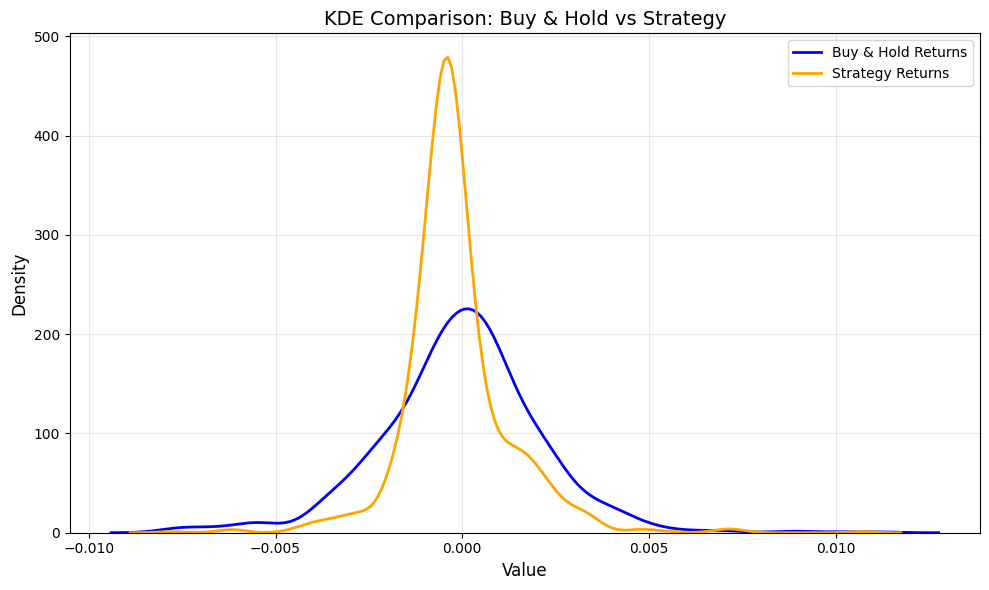

In [ ]:
# Calculate strategy signals
signals = EUR_CHF_15min.groupby(by=EUR_CHF_15min.index.date, as_index=False).apply(get_range, ticks='15 min')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.00000178125
annualized = np.sqrt(252 * 96)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Compound returns Buy & Hold Strategy:  -0.053044346214163984
Compound returns ORB Strategy after commisions:  0.19525755112061938
Compound returns ORB Strategy Before commisions:  0.37930490324194355


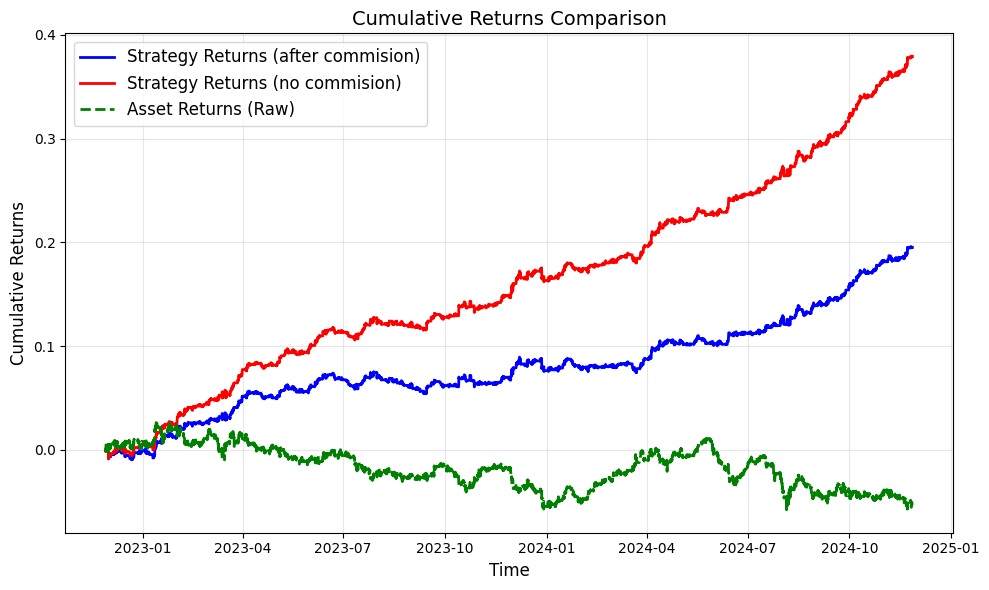

0.49902152641878667
0.5039138943248532
Buy & Hold Returns Metrics:
Mean: -0.000874, Std: 0.000718, Sharpe Ratio: -1.217958

Strategy Returns Metrics:
Mean: 0.000567, Std: 0.000428, Sharpe Ratio: 1.324549


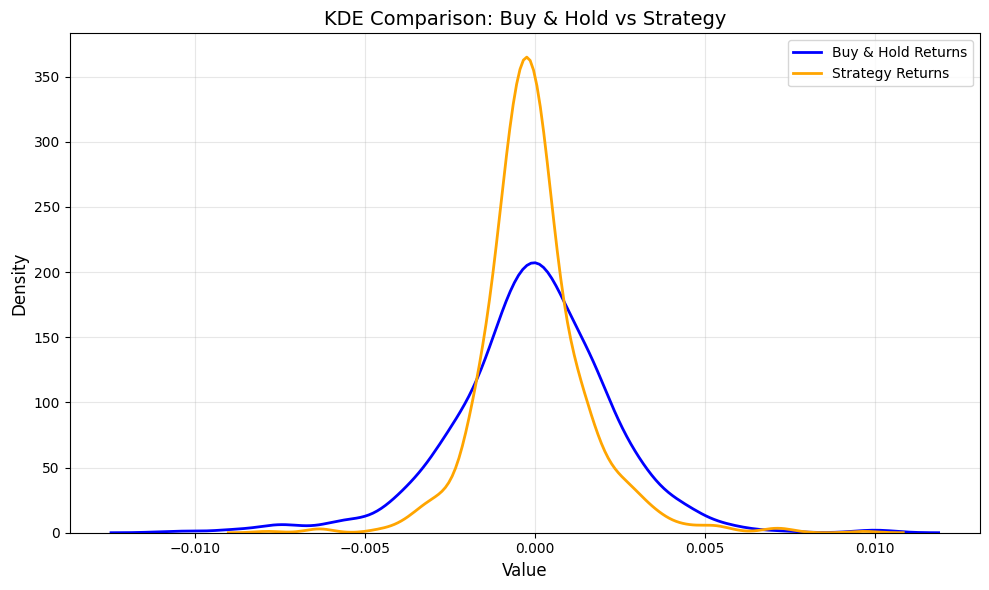

In [ ]:
# Calculate strategy signals
signals = EUR_CHF_1H.groupby(by=EUR_CHF_1H.index.date, as_index=False).apply(get_range, ticks='1 hour')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.000007125
annualized = np.sqrt(252 * 24)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Compound returns Buy & Hold Strategy:  0.3354524410047417
Compound returns ORB Strategy after commisions:  0.9718374455720629
Compound returns ORB Strategy Before commisions:  1.2687719188745894


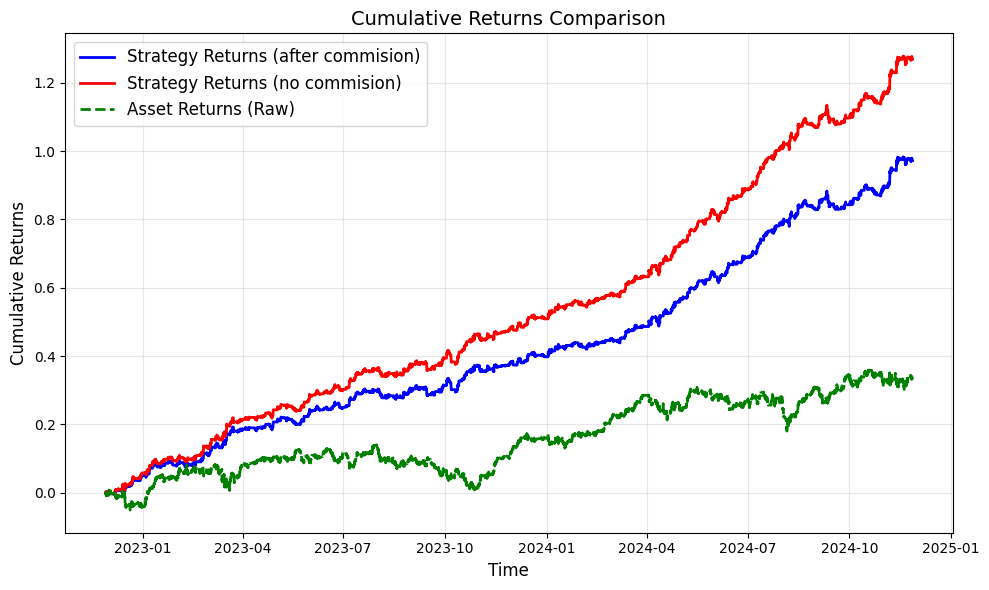

0.5524475524475524
0.5454545454545454
Buy & Hold Returns Metrics:
Mean: 0.004264, Std: 0.001738, Sharpe Ratio: 2.453422

Strategy Returns Metrics:
Mean: 0.009911, Std: 0.001019, Sharpe Ratio: 9.726518


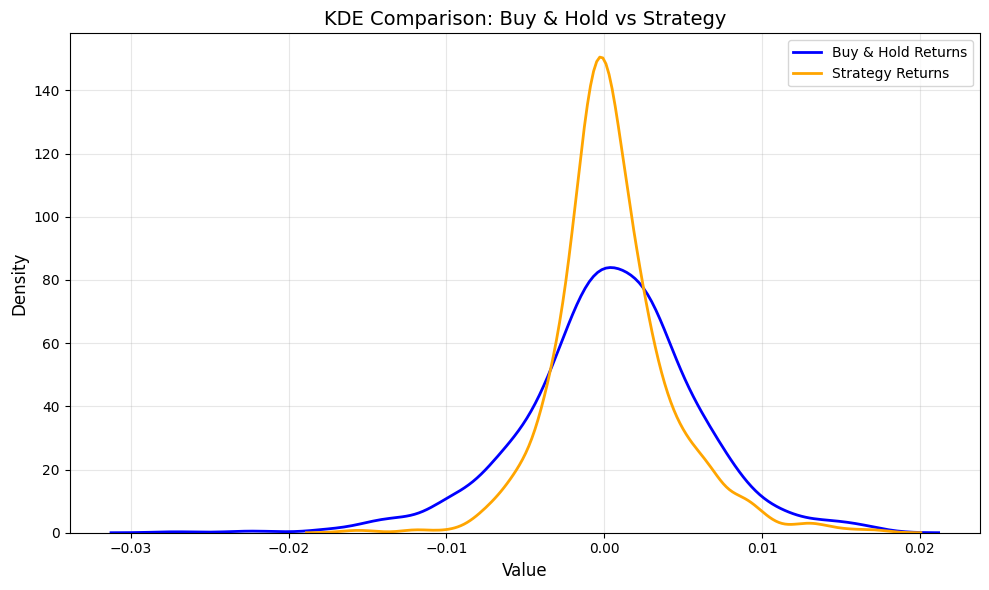

In [ ]:
# Calculate strategy signals
signals = DE30_EUR_15min.groupby(by=DE30_EUR_15min.index.date, as_index=False).apply(get_range, ticks='15 min')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.00000178125
annualized = np.sqrt(252 * 96)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Compound returns Buy & Hold Strategy:  0.33536016583176753
Compound returns ORB Strategy after commisions:  0.6893338586085083
Compound returns ORB Strategy Before commisions:  0.9467530843693848


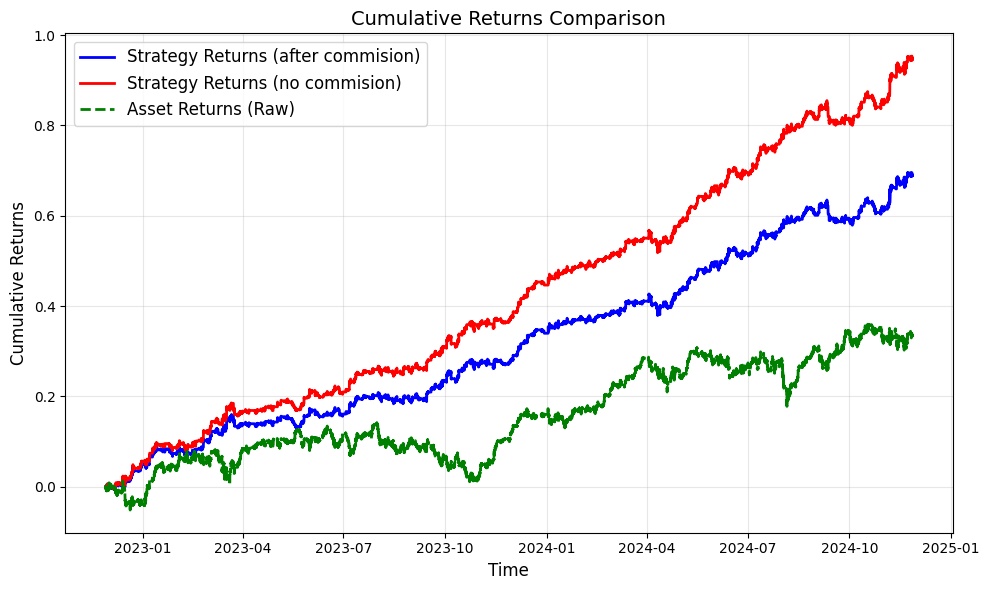

0.4723320158102767
0.5563241106719368
Buy & Hold Returns Metrics:
Mean: 0.000021, Std: 0.000886, Sharpe Ratio: 0.023922

Strategy Returns Metrics:
Mean: 0.000444, Std: 0.000518, Sharpe Ratio: 0.856831


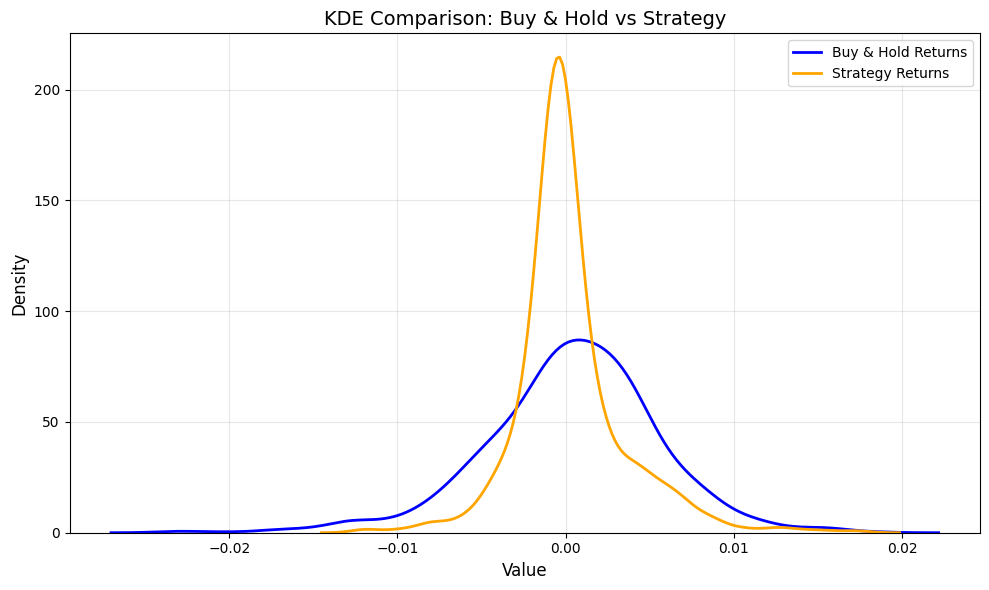

In [ ]:
# Calculate strategy signals
signals = DE30_EUR_1H.groupby(by=DE30_EUR_1H.index.date, as_index=False).apply(get_range, ticks='1 hour')

# Reset index 
signals = signals.reset_index()
signals.index = signals.time
signals = signals.drop(['time', 'level_0'], axis=1)
commision = 1.4 / 10000
risk_free = 0.000007125
annualized = np.sqrt(252 * 24)

# Calculate returns
signals['returns'] = signals['c'].pct_change()

# Calculate returns of strategy
signals['strategy_returns'] = signals['signal'] * signals['returns']
signals['adjusted_returns'] = signals['strategy_returns'].copy()
#Isnt the best but mimics
signals_buysell = ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
signals.loc[signals_buysell ,'adjusted_returns'] = signals.loc[signals_buysell ,'strategy_returns'] - commision
#signals['cumulative_returns'] = 
signals.loc[signals_buysell ]
print('Compound returns Buy & Hold Strategy: ' , (( (1 + signals['returns']).prod() ) - 1))

print('Compound returns ORB Strategy after commisions: ' , (( (1 + signals['adjusted_returns']).prod() ) - 1))
print('Compound returns ORB Strategy Before commisions: ' , (( (1 + signals['strategy_returns'] ).prod()) - 1))

signals['cum_ret_comm'] = ((1 + signals['adjusted_returns']).cumprod()) - 1
signals['cum_ret_no_comm'] =  (1 + signals['strategy_returns']).cumprod() - 1 
signals['cum_ret_buyhold'] =  (1 + signals['returns']).cumprod() - 1
import matplotlib.pyplot as plt

# Plot the strategy's cumulative returns.
plt.figure(figsize=(10, 6))
plt.plot(signals['cum_ret_comm'] , label="Strategy Returns (after commision)", color="blue", linewidth=2)
plt.plot(signals['cum_ret_no_comm'] , label="Strategy Returns (no commision)", color="red", linewidth=2)

# Plot the asset's raw cumulative returns.
plt.plot(signals['cum_ret_buyhold'] , label="Asset Returns (Raw)", color="green", linestyle="--", linewidth=2)

# Add a title, labels, legend, and grid.
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot.
plt.tight_layout()
plt.show()
signals[ ['adjusted_returns','returns']  ].corr()
signals[ ['strategy_returns','returns']  ].corr()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list_strg = []
for x in range(len(changes.iloc[1:])):

    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'adjusted_returns' ] + 1).prod()
    returns_list_strg.append(returns - (1 + 0.000171))
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1
    #print(x)    
    
print(win_rate / n_trades )
data_str = pd.DataFrame(returns_list_strg )
data_str.describe()
is_trade =  ( ( (signals['signal'] == 0) & (signals['signal'].diff() != 0)).shift(-1) | ( (signals['signal'] != 0) & (signals['signal'].diff() != 0)))
changes = signals[is_trade == True ]
n_trades = 0
win_rate = 0 
returns_list = []

for x in range(len(changes.iloc[1:])):    
    returns = (signals.loc[ changes.index[x - 1] : changes.index[x], 'returns' ] + 1).prod()
    returns_list.append(returns- (1 + risk_free) )
    if returns > 1:
        win_rate = win_rate + 1
    n_trades = n_trades + 1

print(win_rate / n_trades )


data_str = pd.DataFrame(returns_list )
data_str.describe()

# Create DataFrames for your data
data_returns = pd.DataFrame(returns_list, columns=["Returns"])
data_strategy = pd.DataFrame(returns_list_strg, columns=["Strategy Returns"])

# Calculate metrics for returns_list
mean_returns = np.mean(signals['returns'] - risk_free) * annualized
std_returns = signals['returns'].std()
sharpe_returns = mean_returns / std_returns if std_returns != 0 else np.nan

# Calculate metrics for returns_list_strg
mean_strategy = np.mean(signals['adjusted_returns'] - risk_free) * annualized
std_strategy = signals['adjusted_returns'].std()
sharpe_strategy = mean_strategy  / (std_strategy) if std_strategy != 0 else np.nan

# Print metrics
print("Buy & Hold Returns Metrics:")
print(f"Mean: {mean_returns:.6f}, Std: {std_returns:.6f}, Sharpe Ratio: {sharpe_returns:.6f}")

print("\nStrategy Returns Metrics:")
print(f"Mean: {mean_strategy:.6f}, Std: {std_strategy:.6f}, Sharpe Ratio: {sharpe_strategy:.6f}")

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE for returns_list
sns.kdeplot(data_returns["Returns"], color='blue', label="Buy & Hold Returns", linewidth=2)

# Plot KDE for returns_list_strg
sns.kdeplot(data_strategy["Strategy Returns"], color='orange', label="Strategy Returns", linewidth=2)

# Add title and labels
plt.title("KDE Comparison: Buy & Hold vs Strategy", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a legend
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
